In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate, Conv2DTranspose, MaxPool2D, Flatten, Conv2D, Reshape, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, UpSampling2D, concatenate, Activation
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv2DTranspose, Input
from keras.saving import register_keras_serializable

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, Concatenate, LeakyReLU, Add
from tensorflow.keras.initializers import he_normal

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.style.use("dark_background")

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

import properscoring as ps

# scaler = MaxAbsScaler()
scaler = MinMaxScaler(feature_range=(0,1))

# tf.random.set_seed(42)  # to replicate results

2024-08-28 14:01:51.258954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 14:01:51.259000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 14:01:51.260061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 14:01:51.266972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 14:01:52.367633: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [3]:
# Get the list of available physical GPUs
gpus = tf.config.list_physical_devices('GPU')

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Create MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2024-08-28 14:01:56.334208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78664 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-08-28 14:01:56.335741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78664 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:44:00.0, compute capability: 8.0
2024-08-28 14:01:56.337120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78664 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:84:00.0, compute capability: 8.0
2024-08-28 14:01:56.338526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78664 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

In [4]:
diri = '/work/bb0983/athul_satheesh/e_obs_precip/'
diro = '/work/bb0983/athul_satheesh/downscaled_data/europe/figures/'

coarse_raw = 'rr_ens_mean_1.0deg_reg_v29.0e.nc'
fine_raw = 'rr_ens_mean_0.1deg_reg_v29.0e.nc'

lati = 43#40
latf = 59#60

loni = -6#-10
lonf = 15#30

strt = '1950-01-01'
last = '2023-12-31'

coarse_data = xr.open_dataset(diri+coarse_raw).rr.transpose('time','lat','lon').sel(time=slice(strt, last), 
                                                                                    lat=slice(lati, latf), 
                                                                                    lon=slice(loni, lonf)
                                                                                   )
fine_data = xr.open_dataset(diri+fine_raw).rr.transpose('time','latitude','longitude').sel(time=slice(strt, last), 
                                                                                           latitude=slice(lati, latf), 
                                                                                           longitude=slice(loni, lonf)
                                                                                          )
fine_data = fine_data.rename({'latitude':'lat', 'longitude':'lon'})

In [5]:
dims_coarse = coarse_data.shape
dims_fine = fine_data.shape

In [6]:
dims_coarse, dims_fine

((27028, 16, 21), (27028, 160, 210))

In [7]:
train_strt = strt
train_last = '2000-12-31'

test_strt = '2001-01-01'
test_last = last

coarse_data_train = coarse_data.sel(time=slice(train_strt, train_last))
coarse_data_test = coarse_data.sel(time=slice(test_strt, test_last))

fine_data_train = fine_data.sel(time=slice(train_strt, train_last))
fine_data_test = fine_data.sel(time=slice(test_strt, test_last))

In [8]:
coarse_nan_mask = np.isnan(coarse_data_test)
fine_nan_mask = np.isnan(fine_data_test)

fill_val = -1e-10

In [9]:
coarse_data_train = coarse_data_train.fillna(fill_val)
coarse_data_test = coarse_data_test.fillna(fill_val)

fine_data_train = fine_data_train.fillna(fill_val)
fine_data_test = fine_data_test.fillna(fill_val)

In [10]:
def ssim_loss(fake_images, real_images):
    """
    Computes the SSIM loss between fake and real images.
    
    Parameters:
        fake_images (tf.Tensor): Generated images.
        real_images (tf.Tensor): Real images.
    
    Returns:
        tf.Tensor: SSIM loss.
    """
    ssim_index = tf.image.ssim(fake_images, real_images, max_val=1.0)
    return 1 - tf.reduce_mean(ssim_index)

In [11]:
def generator_loss(fake_output, fake_images, real_images, penalty_weight=15, ssim_weight=15):
    """
    Generator loss function using Wasserstein loss with an added penalty term and SSIM loss.
    
    Parameters:
        fake_output (tf.Tensor): Output of the discriminator when given generated images.
        fake_images (tf.Tensor): Generated images.
        real_images (tf.Tensor): Real images.
        penalty_weight (float): Weight of the penalty term.
        ssim_weight (float): Weight of the SSIM loss term.
    
    Returns:
        tf.Tensor: Generator loss.
    """
    wasserstein_loss = -tf.reduce_mean(fake_output)
    
    # Penalty term for deviation from real outputs
    # penalty = penalty_weight * tf.reduce_mean(tf.abs(fake_output - real_output))
    penalty = penalty_weight * tf.reduce_mean(tf.abs(fake_images - real_images))
    
    # SSIM loss
    ssim_loss_value = ssim_loss(fake_images, real_images)
    
    return wasserstein_loss + penalty + ssim_weight * ssim_loss_value
    # return wasserstein_loss + ssim_weight * ssim_loss_value

In [12]:
def discriminator_loss(real_output, fake_output):
    """
    Discriminator loss function using Wasserstein loss.
    
    Parameters:
        real_output (tf.Tensor): Output of the discriminator when given real images.
        fake_output (tf.Tensor): Output of the discriminator when given generated images.
    
    Returns:
        tf.Tensor: Discriminator loss.
    """
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

In [13]:
# def discriminator_loss(real_output, fake_output, real_images, fake_images, gradient_penalty_weight=10):
#     """
#     Discriminator loss function using Wasserstein loss and gradient penalty.
    
#     Parameters:
#         real_output (tf.Tensor): Output of the discriminator when given real images.
#         fake_output (tf.Tensor): Output of the discriminator when given generated images.
#         real_images (tf.Tensor): Real images.
#         fake_images (tf.Tensor): Generated images.
#         gradient_penalty_weight (float): Weight of the gradient penalty term.
    
#     Returns:
#         tf.Tensor: Discriminator loss.
#     """
#     wasserstein_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
    
#     # Gradient penalty
#     batch_size = real_images.shape[0]
#     alpha = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)
#     interpolated = alpha * real_images + (1 - alpha) * fake_images
    
#     with tf.GradientTape() as tape:
#         tape.watch(interpolated)
#         interpolated_output = discriminator(interpolated)
    
#     gradients = tape.gradient(interpolated_output, [interpolated])[0]
#     gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
#     gradient_penalty = gradient_penalty_weight * tf.reduce_mean((gradients_norm - 1.0) ** 2)
    
#     return wasserstein_loss + gradient_penalty

In [14]:
# Weight clipping
def clip_weights(model, clip_value):
    """
    Clips the weights of the model to be within the range [-clip_value, clip_value].
    
    Parameters:
        model (tf.keras.Model): The model whose weights will be clipped.
        clip_value (float): The value to clip the weights to.
    """
    for layer in model.layers:
        if hasattr(layer, 'kernel'):
            kernel = layer.kernel
            clipped_kernel = tf.clip_by_value(kernel, -clip_value, clip_value)
            layer.kernel.assign(clipped_kernel)

In [15]:
# # Use a custom dropout layer that is active also during prediction and use this in the model instead of the default Dropout.
# # Alternatively you can also set "training=True" in the Dropout layer
# @register_keras_serializable()
# class CustomDropout(Dropout):
#     def __init__(self, rate, **kwargs):
#         super(CustomDropout, self).__init__(rate, **kwargs)

#     def call(self, inputs, training=None):
#         return super().call(inputs, training=True)  # Always active

In [16]:
# @register_keras_serializable()
# class RandomDropout(tf.keras.layers.Dropout):
#     def __init__(self, min_rate=0.25, max_rate=0.35, **kwargs):
#         # Pass a dummy rate (e.g., 0.0) to satisfy the base class constructor
#         super(RandomDropout, self).__init__(rate=0.0, **kwargs)
#         self.min_rate = min_rate
#         self.max_rate = max_rate

#     def call(self, inputs, training=None):
#         # Apply dropout with a random rate between min_rate and max_rate
#         self.rate = np.random.uniform(self.min_rate, self.max_rate)
#         return super(RandomDropout, self).call(inputs, training=True)  # Force dropout always

#     def get_config(self):
#         config = super(RandomDropout, self).get_config()
#         config.update({
#             'min_rate': self.min_rate,
#             'max_rate': self.max_rate,
#         })
#         return config

In [17]:
def conv_block(x, filters, kernel_size, name, dilation_rate, strides=(1,1), use_batch_norm=True, use_dropout=True):
    x = Conv2D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, strides=strides, padding='same', 
               kernel_initializer=he_normal(), name=name+'_conv')(x)
    x = LeakyReLU(alpha=0.2, name=name+'_lrelu')(x)
    if use_batch_norm:
        x = BatchNormalization(name=name+'_bn')(x)
    if use_dropout:
        # Generate a random dropout rate between 0.25 and 0.35
        rate = np.random.uniform(0.25, 0.35)
        x = tf.keras.layers.Dropout(rate=rate, name=name+'_dropout')(x, training=True)
    return x

def deconv_block(x, filters, kernel_size, strides, name, dilation_rate, use_batch_norm=True, use_dropout=True):
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, strides=strides, 
                        padding='same', kernel_initializer=he_normal(), name=name+'_deconv')(x)
    x = LeakyReLU(alpha=0.2, name=name+'_lrelu')(x)
    if use_batch_norm:
        x = BatchNormalization(name=name+'_bn')(x)
    if use_dropout:
        # Generate a random dropout rate between 0.25 and 0.35
        rate = np.random.uniform(0.25, 0.35)
        x = tf.keras.layers.Dropout(rate=rate, name=name+'_dropout')(x, training=True)
    return x

In [18]:
# def conv_block(x, filters, kernel_size, name, dilation_rate, strides=(1,1), use_batch_norm=True, use_dropout=True):
#     x = Conv2D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, strides=strides, padding='same', 
#                kernel_initializer=he_normal(), name=name+'_conv')(x)
#     x = LeakyReLU(alpha=0.2, name=name+'_lrelu')(x)
#     if use_batch_norm:
#         x = BatchNormalization(name=name+'_bn')(x)
#     if use_dropout:
#         # x = Dropout(0.25, name=name+'_dropout')(x, training=True)
#         # x = CustomDropout(0.30, name=name+'_dropout')(x)
#         x = RandomDropout(min_rate=0.25, max_rate=0.35, name=name+'_dropout')(x)
#     return x

# def deconv_block(x, filters, kernel_size, strides, name, dilation_rate, use_batch_norm=True, use_dropout=True):
#     x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, strides=strides, 
#                         padding='same', kernel_initializer=he_normal(), name=name+'_deconv')(x)
#     x = LeakyReLU(alpha=0.2, name=name+'_lrelu')(x)
#     if use_batch_norm:
#         x = BatchNormalization(name=name+'_bn')(x)
#     if use_dropout:
#         # x = CustomDropout(0.30, name=name+'_dropout')(x)
#         x = RandomDropout(min_rate=0.25, max_rate=0.35, name=name+'_dropout')(x)
#     return x

# def upsampling_block(inputs, filters, kernel_size, upsample_factor, name, dilation_rate, strides, use_batch_norm=True, use_dropout=True):
#     x = UpSampling2D(size=upsample_factor, name=name+'_upsample')(inputs)
#     x = Conv2D(filters, kernel_size, dilation_rate=dilation_rate, padding='same', strides=strides,
#                kernel_initializer=he_normal(), name=name+'_conv')(x)
#     x = LeakyReLU(alpha=0.2, name=name+'_lrelu')(x)
#     if use_batch_norm:
#         x = BatchNormalization(name=name+'_bn')(x)
#     if use_dropout:
#         x = CustomDropout(0.25, name=name+'_dropout')(x)
#     return x

In [19]:
# def build_generator(input_shape):
#     inputs = Input(shape=input_shape, name='generator_input')

#     # Downsampling
#     downsample_3 = conv_block(inputs, 512, (3, 3), 'downsample_3', (1,1))
#     downsample_2 = conv_block(downsample_3, 256, (3, 3), 'downsample_2', (1,1))
#     downsample_1 = conv_block(downsample_2, 128, (3, 3), 'downsample_1', (1,1))
#     downsample_0 = conv_block(downsample_1, 64, (3, 3), 'downsample_0', (1,1))

#     # Bottleneck
#     bottleneck_0 = conv_block(downsample_0, 32, (3, 3), 'bottleneck_0', (1,1))
#     bottleneck_00 = conv_block(bottleneck_0, 32, (3, 3), 'bottleneck_00', (1,1))

#     # Upsampling
#     upsample_0 = upsampling_block(bottleneck_00, 64, (3, 3), (1,1), 'upsample_0', (1,1), (1,1))
#     upsample_1 = upsampling_block(upsample_0, 128, (3, 3), (1,1), 'upsample_1', (1,1), (1,1))
#     upsample_2 = upsampling_block(upsample_1, 256, (3, 3), (2,2), 'upsample_2', (1,1), (1,1))
#     upsample_3 = upsampling_block(upsample_2, 512, (6, 6), (5,5), 'upsample_3', (1,1), (1,1))
    
#     # Final Upsample to required shape
#     outputs = Conv2D(filters=1, kernel_size=(3, 3), kernel_initializer=he_normal(), padding='same', 
#                               strides=(1, 1), activation='relu', name='final_upsample_conv')(upsample_3)
    
#     model = Model(inputs=inputs, outputs=outputs, name='generator')
    
#     return model

In [20]:
# def build_generator(input_shape):
#     inputs = Input(shape=input_shape, name='generator_input')

#     # Convolutions
#     conv_3 = conv_block(inputs, 512, (3, 3), 'conv_3', (1,1))
#     conv_2 = conv_block(conv_3, 256, (3, 3), 'conv_2', (1,1))
#     conv_1 = conv_block(conv_2, 128, (3, 3), 'conv_1', (1,1))
#     conv_0 = conv_block(conv_1, 64, (3, 3), 'conv_0', (1,1))
    
#     # Bottleneck
#     bottleneck_0 = conv_block(conv_0, 32, (3, 3), 'bottleneck_0', (1,1))
#     bottleneck_00 = conv_block(bottleneck_0, 32, (3, 3), 'bottleneck_00', (1,1))
    
#     # Upsampling with skip connections
#     deconv_0 = deconv_block(bottleneck_00, 64, (3, 3), (1,1), 'deconv_0', (1,1))
#     deconv_1 = deconv_block(deconv_0, 128, (3, 3), (1,1), 'deconv_1', (1,1))
#     deconv_2 = deconv_block(deconv_1, 256, (3, 3), (2,2), 'deconv_2', (1,1))
#     deconv_3 = deconv_block(deconv_2, 512, (6, 6), (5,5), 'deconv_3', (1,1))
    
#     # Final Upsample to required shape
#     outputs = Conv2D(filters=1, kernel_size=(3, 3), kernel_initializer=he_normal(), padding='same', 
#                               strides=(1, 1), activation='relu', name='final_conv')(deconv_3)
    
#     model = Model(inputs=inputs, outputs=outputs, name='generator')
    
#     return model

In [21]:
def build_generator(input_shape):
    inputs = Input(shape=input_shape, name='generator_input')

    # Convolutions
    conv_4 = conv_block(inputs, 16, (3, 3), 'conv_4', (1,1))
    conv_3 = conv_block(conv_4, 32, (3, 3), 'conv_3', (1,1))
    conv_2 = conv_block(conv_3, 64, (3, 3), 'conv_2', (1,1))
    conv_1 = conv_block(conv_2, 128, (3, 3), 'conv_1', (1,1))
    conv_0 = conv_block(conv_1, 256, (3, 3), 'conv_0', (1,1))
    conv_00 = conv_block(conv_0, 512, (3, 3), 'conv_00', (1,1))
    
    # Upsampling
    deconv_00 = deconv_block(conv_00, 512, (3, 3), (1,1), 'deconv_00', (1,1))
    deconv_0 = deconv_block(deconv_00, 256, (3, 3), (1,1), 'deconv_0', (1,1))
    deconv_1 = deconv_block(deconv_0, 128, (3, 3), (1,1), 'deconv_1', (1,1))
    deconv_2 = deconv_block(deconv_1, 64, (3, 3), (1,1), 'deconv_2', (1,1))
    # deconv_3 = deconv_block(deconv_2, 32, (3, 3), (2,2), 'deconv_3', (1,1))
    deconv_3 = deconv_block(deconv_2, 32, (3, 3), (1,1), 'deconv_3', (1,1))
    deconv_4 = deconv_block(deconv_3, 16, (6, 6), (5,5), 'deconv_4', (1,1))
    
    # Final Upsample to required shape
    # outputs = Conv2D(filters=1, kernel_size=(3, 3), kernel_initializer=he_normal(), padding='same', 
    #                           strides=(1, 1), activation='relu', name='final_conv')(deconv_4)
    outputs = Conv2DTranspose(filters=1, kernel_size=(3, 3), kernel_initializer=he_normal(), padding='same', 
                              strides=(2, 2), activation='relu', name='final_deconv')(deconv_4)
    
    model = Model(inputs=inputs, outputs=outputs, name='generator')
    
    return model

In [22]:
# def build_generator(input_shape):
#     inputs = Input(shape=input_shape, name='generator_input')

#     # Convolutions
#     # conv_4 = conv_block(inputs, 16, (3, 3), 'conv_4', (1,1))
#     # conv_3 = conv_block(conv_4, 32, (3, 3), 'conv_3', (1,1))
#     # conv_2 = conv_block(conv_3, 64, (3, 3), 'conv_2', (1,1))
#     conv_1 = conv_block(inputs, 256, (3, 3), 'conv_1', (1,1))
#     conv_0 = conv_block(conv_1, 256, (3, 3), 'conv_0', (1,1))
#     conv_00 = conv_block(conv_0, 256, (3, 3), 'conv_00', (1,1))
    
#     # Upsampling
#     deconv_00 = deconv_block(conv_00, 256, (3, 3), (1,1), 'deconv_00', (1,1))
#     deconv_0 = deconv_block(deconv_00, 256, (3, 3), (1,1), 'deconv_0', (1,1))
#     deconv_1 = deconv_block(deconv_0, 256, (6, 6), (5,5), 'deconv_1', (1,1))
#     # deconv_2 = deconv_block(deconv_1, 64, (3, 3), (1,1), 'deconv_2', (1,1))
#     # # deconv_3 = deconv_block(deconv_2, 32, (3, 3), (2,2), 'deconv_3', (1,1))
#     # deconv_3 = deconv_block(deconv_2, 32, (3, 3), (1,1), 'deconv_3', (1,1))
#     # deconv_4 = deconv_block(deconv_3, 16, (6, 6), (5,5), 'deconv_4', (1,1))
    
#     # Final Upsample to required shape
#     # outputs = Conv2D(filters=1, kernel_size=(3, 3), kernel_initializer=he_normal(), padding='same', 
#     #                           strides=(1, 1), activation='relu', name='final_conv')(deconv_4)
#     outputs = Conv2DTranspose(filters=1, kernel_size=(3, 3), kernel_initializer=he_normal(), padding='same', 
#                               strides=(2, 2), activation='relu', name='final_deconv')(deconv_1)
    
#     model = Model(inputs=inputs, outputs=outputs, name='generator')
    
#     return model

In [23]:
# def build_discriminator(input_shape):
#     input_layer = Input(shape=input_shape, name='discriminator_input')

#     x = conv_block(input_layer, filters=256, kernel_size=(3, 3), name='conv1', dilation_rate=(1,1), strides=(1,1), use_dropout=False, use_batch_norm=False)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = conv_block(x, filters=256, kernel_size=(3, 3), name='conv2', dilation_rate=(1,1), strides=(1,1), use_dropout=False, use_batch_norm=False)
#     # x = MaxPooling2D(pool_size=(2,2))(x)
#     # x = conv_block(x, filters=32, kernel_size=(3, 3), name='conv2', dilation_rate=(1,1), strides=(1,1), use_dropout=False, use_batch_norm=False)
#     # x = MaxPooling2D(pool_size=(2,2))(x)
#     # x = conv_block(x, filters=64, kernel_size=(3, 3), name='conv3', dilation_rate=(1,1), strides=(1,1), use_dropout=False, use_batch_norm=False)
#     # x = MaxPooling2D(pool_size=(2,2))(x)
#     # x = conv_block(input_layer, filters=128, kernel_size=(3, 3), name='conv4', dilation_rate=(1,1), strides=(1,1), use_dropout=False, use_batch_norm=False)
#     # x = MaxPooling2D(pool_size=(2,2))(x)
#     # x = conv_block(x, filters=256, kernel_size=(3, 3), name='conv5', dilation_rate=(1,1), strides=(1,1), use_dropout=False, use_batch_norm=False)
#     # x = MaxPooling2D(pool_size=(2,2))(x)
#     # x = conv_block(x, filters=512, kernel_size=(3, 3), name='conv6', dilation_rate=(1,1), strides=(1,1), use_dropout=False, use_batch_norm=False)
#     # x = MaxPooling2D(pool_size=(2,2))(x)
#     # x = conv_block(input_layer, filters=1024, kernel_size=(3, 3), name='conv7', dilation_rate=(1,1), strides=(1,1), use_dropout=False, use_batch_norm=False)
#     # x = MaxPooling2D(pool_size=(2,2))(x)
#     # x = Dropout(0.25)(x)
#     # x = Flatten()(x)
#     # output_layer = Dense(1, activation='linear')(x)
#     output_layer = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2,2), padding='same', activation='linear', name='final_conv')(x)
    
#     model = Model(inputs=input_layer, outputs=output_layer, name='wGAN_discriminator')
    
#     return model

In [24]:
def build_discriminator(input_shape):
    input_layer = Input(shape=input_shape, name='discriminator_input')

    x = conv_block(input_layer, filters=128, kernel_size=(3, 3), name='conv1', dilation_rate=(1,1), strides=(2,2), use_dropout=False)
    # x = MaxPooling2D(pool_size=(2,2))(x)
    # x = conv_block(x, filters=512, kernel_size=(3, 3), name='conv2', dilation_rate=(1,1), strides=(1,1), use_dropout=False)
    # x = MaxPooling2D(pool_size=(2,2))(x)
    x = conv_block(x, filters=256, kernel_size=(3, 3), name='conv3', dilation_rate=(1,1), strides=(1,1), use_dropout=False)
    # x = MaxPooling2D(pool_size=(2,2))(x)
    # x = conv_block(x, filters=512, kernel_size=(3, 3), name='conv4', dilation_rate=(1,1), strides=(1,1), use_dropout=False)
    # x = MaxPooling2D(pool_size=(2,2))(x)
    x = conv_block(x, filters=512, kernel_size=(3, 3), name='conv5', dilation_rate=(1,1), strides=(1,1), use_dropout=False)
    x = MaxPooling2D(pool_size=(2,2))(x)
    # x = conv_block(x, filters=512, kernel_size=(3, 3), name='conv6', dilation_rate=(1,1), strides=(1,1), use_dropout=False)
    # x = MaxPooling2D(pool_size=(2,2))(x)
    
    # x = Dropout(0.25)(x)
    # output_layer = Dense(1, activation='linear')(x)
    output_layer = Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear', name='final_conv')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='wGAN_discriminator')
    
    return model

In [25]:
input_shape  = dims_coarse[1:] + (1,)
output_shape = dims_fine[1:] + (1,)

# lr = 0.5e-5
gen_lr = 2e-4
dis_lr = 1e-5
clip_value = 1e-3


with strategy.scope():
    
    # gen_optimizer = RMSprop(learning_rate=lr, momentum=0.5)
    # dis_optimizer = RMSprop(learning_rate=lr, momentum=0.5)
    gen_optimizer = Adam(learning_rate=gen_lr)
    dis_optimizer = Adam(learning_rate=dis_lr)
    
    gen = build_generator(input_shape)
    dis = build_discriminator(output_shape)

    gen.compile(optimizer=gen_optimizer,)
    dis.compile(optimizer=dis_optimizer,)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [26]:
gen.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLaye  [(None, 16, 21, 1)]       0         
 r)                                                              
                                                                 
 conv_4_conv (Conv2D)        (None, 16, 21, 16)        160       
                                                                 
 conv_4_lrelu (LeakyReLU)    (None, 16, 21, 16)        0         
                                                                 
 conv_4_bn (BatchNormalizat  (None, 16, 21, 16)        64        
 ion)                                                            
                                                                 
 conv_4_dropout (Dropout)    (None, 16, 21, 16)        0         
                                                                 
 conv_3_conv (Conv2D)        (None, 16, 21, 32)        46

In [27]:
dis.summary()

Model: "wGAN_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 160, 210, 1)]     0         
 Layer)                                                          
                                                                 
 conv1_conv (Conv2D)         (None, 80, 105, 128)      1280      
                                                                 
 conv1_lrelu (LeakyReLU)     (None, 80, 105, 128)      0         
                                                                 
 conv1_bn (BatchNormalizati  (None, 80, 105, 128)      512       
 on)                                                             
                                                                 
 conv3_conv (Conv2D)         (None, 80, 105, 256)      295168    
                                                                 
 conv3_lrelu (LeakyReLU)     (None, 80, 105, 256

In [28]:
# Convert data to tensor
def preprocess_data(data):
    data = tf.convert_to_tensor(data.values, dtype=tf.float32)
    return tf.reshape(data, data.shape + (1,))
# Compute and update gradients
def train_step(coarse_data_batch, fine_data_batch, dis, clip_value):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        fake_data_batch = gen(coarse_data_batch, training=True)
        real_output = dis(fine_data_batch, training=True)
        fake_output = dis(fake_data_batch, training=True)
        gen_loss = generator_loss(fake_output, fake_data_batch, fine_data_batch)
        dis_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_dis = dis_tape.gradient(dis_loss, dis.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_gen, gen.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradients_of_dis, dis.trainable_variables))
    
    # Clip discriminator weights
    clip_weights(dis, clip_value)
    
    return gen_loss, dis_loss

@tf.function
def distributed_train_step(coarse_data_batch, fine_data_batch, dis, clip_value):
    per_replica_gen_losses, per_replica_dis_losses = strategy.run(train_step, args=(coarse_data_batch, fine_data_batch, dis, clip_value))
    mean_gen_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_gen_losses, axis=None)
    mean_dis_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_dis_losses, axis=None)
    return mean_gen_loss, mean_dis_loss

def train_gan(gen, dis, coarse_data_train, fine_data_train, clip_value, epochs, batch_size, save_intermediate=True):
    dataset = tf.data.Dataset.from_tensor_slices((preprocess_data(coarse_data_train), preprocess_data(fine_data_train)))
    # dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).repeat(epochs)
    dataset = dataset.shuffle(buffer_size=365*2).batch(batch_size)#.repeat(epochs)
    distributed_dataset = strategy.experimental_distribute_dataset(dataset)

    for epoch in range(epochs):
        total_gen_loss = 0.0
        total_dis_loss = 0.0
        num_batches = 0

        for coarse_data_batch, fine_data_batch in distributed_dataset:
            gen_loss, dis_loss = distributed_train_step(coarse_data_batch, fine_data_batch, dis, clip_value)
            total_gen_loss += gen_loss
            total_dis_loss += dis_loss
            num_batches += 1

        avg_gen_loss = total_gen_loss / num_batches
        avg_dis_loss = total_dis_loss / num_batches
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Generator Loss: {avg_gen_loss:.5f}, Discriminator Loss: {avg_dis_loss:.5f}")

        # Save models every 100 epochs
        if save_intermediate:
            if (epoch + 1) % 50 == 0:
                gen.save(f'/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/wgan_gp_extended_eu/generator_prob_epoch_{epoch+1}_adamV5.keras')
                dis.save(f'/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/wgan_gp_extended_eu/discriminator_prob_epoch_{epoch+1}_adamV5.keras')

# Modification: Train the critic 5x as much for one iteration of generator training 
# def train_gan(gen, dis, coarse_data_train, fine_data_train, clip_value, epochs, batch_size, n_critic=3, save_intermediate=True):
#     dataset = tf.data.Dataset.from_tensor_slices((preprocess_data(coarse_data_train), preprocess_data(fine_data_train)))
#     dataset = dataset.shuffle(buffer_size=365*2).batch(batch_size)
#     distributed_dataset = strategy.experimental_distribute_dataset(dataset)

#     for epoch in range(epochs):
#         total_gen_loss = 0.0
#         total_dis_loss = 0.0
#         num_batches = 0

#         for coarse_data_batch, fine_data_batch in distributed_dataset:
#             # Train the discriminator for n_critic iterations
#             for _ in range(n_critic):
#                 _, dis_loss = distributed_train_step(coarse_data_batch, fine_data_batch, dis, clip_value)
#                 total_dis_loss += dis_loss
#                 num_batches += 1

#             # Train the generator once
#             gen_loss, _ = distributed_train_step(coarse_data_batch, fine_data_batch, dis, clip_value)
#             total_gen_loss += gen_loss

#         avg_gen_loss = total_gen_loss / num_batches
#         avg_dis_loss = total_dis_loss / (num_batches * n_critic)

#         if (epoch + 1) % 10 == 0:
#             print(f"Epoch {epoch + 1}, Generator Loss: {avg_gen_loss:.5f}, Discriminator Loss: {avg_dis_loss:.5f}")

#         # Save models every 100 epochs
#         if save_intermediate:
#             if (epoch + 1) % 50 == 0:
#                 gen.save(f'/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/wgan_gp_extended_eu/generator_prob_epoch_{epoch+1}_adamV5.keras')
#                 dis.save(f'/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/wgan_gp_extended_eu/discriminator_prob_epoch_{epoch+1}_adamV5.keras')

In [29]:
# def preprocess_data(data):
#     data = tf.convert_to_tensor(data.values, dtype=tf.float32)
#     return tf.reshape(data, data.shape + (1,))

# # Compute and update gradients
# def train_discriminator_step(coarse_data_batch, fine_data_batch, dis, clip_value):
#     with tf.GradientTape() as dis_tape:
#         fake_data_batch = gen(coarse_data_batch, training=True)
#         real_output = dis(fine_data_batch, training=True)
#         fake_output = dis(fake_data_batch, training=True)
#         dis_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_dis = dis_tape.gradient(dis_loss, dis.trainable_variables)
#     dis_optimizer.apply_gradients(zip(gradients_of_dis, dis.trainable_variables))
    
#     # Clip discriminator weights
#     clip_weights(dis, clip_value)
    
#     return dis_loss

# def train_generator_step(coarse_data_batch, fine_data_batch, dis):
#     with tf.GradientTape() as gen_tape:
#         fake_data_batch = gen(coarse_data_batch, training=True)
#         fake_output = dis(fake_data_batch, training=True)
#         real_output = dis(fine_data_batch, training=True)
#         gen_loss = generator_loss(fake_output, real_output, fake_data_batch, fine_data_batch)

#     gradients_of_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
#     gen_optimizer.apply_gradients(zip(gradients_of_gen, gen.trainable_variables))
    
#     return gen_loss

# @tf.function
# def distributed_discriminator_step(coarse_data_batch, fine_data_batch, dis, clip_value):
#     per_replica_dis_losses = strategy.run(train_discriminator_step, args=(coarse_data_batch, fine_data_batch, dis, clip_value))
#     mean_dis_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_dis_losses, axis=None)
#     return mean_dis_loss

# @tf.function
# def distributed_generator_step(coarse_data_batch, fine_data_batch, dis):
#     per_replica_gen_losses = strategy.run(train_generator_step, args=(coarse_data_batch, fine_data_batch, dis))
#     mean_gen_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_gen_losses, axis=None)
#     return mean_gen_loss

# def train_gan(gen, dis, coarse_data_train, fine_data_train, clip_value, epochs, batch_size, save_intermediate=True, d_steps=5):
#     dataset = tf.data.Dataset.from_tensor_slices((preprocess_data(coarse_data_train), preprocess_data(fine_data_train)))
#     dataset = dataset.shuffle(buffer_size=365*2).batch(batch_size)
#     distributed_dataset = strategy.experimental_distribute_dataset(dataset)

#     for epoch in range(epochs):
#         total_gen_loss = 0.0
#         total_dis_loss = 0.0
#         num_batches = 0

#         for coarse_data_batch, fine_data_batch in distributed_dataset:
#             for _ in range(d_steps):
#                 dis_loss = distributed_discriminator_step(coarse_data_batch, fine_data_batch, dis, clip_value)
#                 total_dis_loss += dis_loss
#                 num_batches += 1

#             gen_loss = distributed_generator_step(coarse_data_batch, fine_data_batch, dis)
#             total_gen_loss += gen_loss

#         avg_gen_loss = total_gen_loss / num_batches
#         avg_dis_loss = total_dis_loss / (num_batches * d_steps)
        
#         if (epoch + 1) % 10 == 0:
#             print(f"Epoch {epoch + 1}, Generator Loss: {avg_gen_loss:.5f}, Discriminator Loss: {avg_dis_loss:.5f}")

#         # Save models every 100 epochs
#         if save_intermediate and (epoch + 1) % 50 == 0:
#             gen.save(f'/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/wgan_gp_extended_eu/generator_prob_epoch_{epoch+1}.keras')
#             dis.save(f'/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/wgan_gp_extended_eu/discriminator_prob_epoch_{epoch+1}.keras')

In [30]:
epochs = 1000
batch_size = 365*2

In [31]:
%%time
train_gan(gen, dis, coarse_data_train, fine_data_train, clip_value, epochs, batch_size, save_intermediate=True)

INFO:tensorflow:Collective all_reduce tensors: 50 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 14 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 50 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 14 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-08-28 14:02:56.303072: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inreplica_2/generator/conv_4_dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-28 14:02:57.959439: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-28 14:02:58.099681: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-28 14:02:58.114783: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-28 14:02:58.285569: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-28 14:02:58.299586: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-28 14:02:58.337757: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot

INFO:tensorflow:Collective all_reduce tensors: 50 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 14 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-08-28 14:08:12.550887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inreplica_2/generator/conv_4_dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 10, Generator Loss: 100.15952, Discriminator Loss: -5.28171
Epoch 20, Generator Loss: 86.31190, Discriminator Loss: -6.03382
Epoch 30, Generator Loss: 79.82795, Discriminator Loss: -5.89693
Epoch 40, Generator Loss: 75.84341, Discriminator Loss: -5.74989
Epoch 50, Generator Loss: 73.04316, Discriminator Loss: -5.46569
Epoch 60, Generator Loss: 70.85298, Discriminator Loss: -5.05886
Epoch 70, Generator Loss: 69.00279, Discriminator Loss: -4.55343
Epoch 80, Generator Loss: 67.12350, Discriminator Loss: -4.05488
Epoch 90, Generator Loss: 65.56418, Discriminator Loss: -3.69084
Epoch 100, Generator Loss: 64.52619, Discriminator Loss: -3.53310
Epoch 110, Generator Loss: 63.73567, Discriminator Loss: -3.24497
Epoch 120, Generator Loss: 62.91529, Discriminator Loss: -3.18410
Epoch 130, Generator Loss: 62.36095, Discriminator Loss: -3.10664
Epoch 140, Generator Loss: 62.01099, Discriminator Loss: -2.86545
Epoch 150, Generator Loss: 61.55022, Discriminator Loss: -2.84101
Epoch 160, Generat

In [32]:
# Unset the random seed to generate ensembles
tf.random.set_seed(None) 

downscaled_data_mem1 = gen.predict( coarse_data_test.values.reshape( coarse_data_test.shape + (1,) ) )
downscaled_data_mem2 = gen.predict( coarse_data_test.values.reshape( coarse_data_test.shape + (1,) ) )
downscaled_data_mem3 = gen.predict( coarse_data_test.values.reshape( coarse_data_test.shape + (1,) ) )
downscaled_data_mem4 = gen.predict( coarse_data_test.values.reshape( coarse_data_test.shape + (1,) ) )
downscaled_data_mem5 = gen.predict( coarse_data_test.values.reshape( coarse_data_test.shape + (1,) ) )
downscaled_data_mem6 = gen.predict( coarse_data_test.values.reshape( coarse_data_test.shape + (1,) ) )

2024-08-28 19:30:28.823583: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingenerator/conv_4_dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


263/263 [==============================] - 2s 4ms/step


In [33]:
downscaled_data_mem1.shape, downscaled_data_mem2.shape, downscaled_data_mem3.shape, downscaled_data_mem4.shape, downscaled_data_mem5.shape, downscaled_data_mem6.shape

((8400, 160, 210, 1),
 (8400, 160, 210, 1),
 (8400, 160, 210, 1),
 (8400, 160, 210, 1),
 (8400, 160, 210, 1),
 (8400, 160, 210, 1))

In [34]:
# downscaled_data = inverse_normalize_data(downscaled_data, scaler)

In [35]:
downscaled_data_mem1 = xr.DataArray(name='precipitation', data=downscaled_data_mem1.squeeze(), 
                               dims=fine_data_test.dims, coords=fine_data_test.coords, 
                               attrs=fine_data_test.attrs)
downscaled_data_mem1 = downscaled_data_mem1.where(~fine_nan_mask, np.nan)

downscaled_data_mem2 = xr.DataArray(name='precipitation', data=downscaled_data_mem2.squeeze(), 
                               dims=fine_data_test.dims, coords=fine_data_test.coords, 
                               attrs=fine_data_test.attrs)
downscaled_data_mem2 = downscaled_data_mem2.where(~fine_nan_mask, np.nan)

downscaled_data_mem3 = xr.DataArray(name='precipitation', data=downscaled_data_mem3.squeeze(), 
                               dims=fine_data_test.dims, coords=fine_data_test.coords, 
                               attrs=fine_data_test.attrs)
downscaled_data_mem3 = downscaled_data_mem3.where(~fine_nan_mask, np.nan)

downscaled_data_mem4 = xr.DataArray(name='precipitation', data=downscaled_data_mem4.squeeze(), 
                               dims=fine_data_test.dims, coords=fine_data_test.coords, 
                               attrs=fine_data_test.attrs)
downscaled_data_mem4 = downscaled_data_mem4.where(~fine_nan_mask, np.nan)

downscaled_data_mem5 = xr.DataArray(name='precipitation', data=downscaled_data_mem5.squeeze(), 
                               dims=fine_data_test.dims, coords=fine_data_test.coords, 
                               attrs=fine_data_test.attrs)
downscaled_data_mem5 = downscaled_data_mem5.where(~fine_nan_mask, np.nan)

downscaled_data_mem6 = xr.DataArray(name='precipitation', data=downscaled_data_mem6.squeeze(), 
                               dims=fine_data_test.dims, coords=fine_data_test.coords, 
                               attrs=fine_data_test.attrs)
downscaled_data_mem6 = downscaled_data_mem6.where(~fine_nan_mask, np.nan)

In [36]:
downscaled_data_list = [downscaled_data_mem1, downscaled_data_mem2, downscaled_data_mem3, 
                   downscaled_data_mem4, downscaled_data_mem5, downscaled_data_mem6
                  ]
downscaled_data = xr.concat(downscaled_data_list, dim='number')
downscaled_data = downscaled_data.assign_coords(number=np.arange( len(downscaled_data_list)) )
downscaled_data = downscaled_data.transpose('time', 'lat', 'lon', 'number')

In [37]:
downscaled_data

<xarray.DataArray 'precipitation' (time: 8400, lat: 160, lon: 210, number: 6)> Size: 7GB
array([[[[1.06833720e+00, 4.38261747e-01, 1.49917889e+00,
          0.00000000e+00, 5.72689056e-01, 1.11596560e+00],
         [1.01360393e+00, 1.16016507e-01, 2.02267885e+00,
          0.00000000e+00, 4.30168986e-01, 1.02182221e+00],
         [6.43758535e-01, 0.00000000e+00, 1.67008686e+00,
          0.00000000e+00, 2.52364755e-01, 8.34173858e-01],
         ...,
         [           nan,            nan,            nan,
                     nan,            nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan,            nan]],

        [[1.02966809e+00, 5.89692652e-01, 1.44004095e+00,
          0.00000000e+00, 5.54773748e-01, 1.27997899e+00],
         [9.91802037e-01, 0.00000000e+00, 1.87142313e+00,
          0.00000000e+00, 0.00000000e+00, 1.30941749e+00],
         [9.51971292e-01, 0.00000000e+00, 1.79922938e+00,
          0.00000000e+00, 0.00000000e+00, 9.63719726e-01],
...
          1.98980081e+00, 2.75180149e+00, 2.27388477e+00],
         [2.65303326e+00, 1.51216388e+00, 2.31407189e+00,
          1.98730302e+00, 2.62910223e+00, 2.16204453e+00],
         [2.23129272e+00, 1.48315656e+00, 2.12900972e+00,
          2.02212596e+00, 2.65436149e+00, 1.86056364e+00]],

        [[           nan,            nan,            nan,
                     nan,            nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan,            nan],
         ...,
         [2.80068350e+00, 1.80983782e+00, 2.91978741e+00,
          2.18636870e+00, 3.03452778e+00, 2.69116068e+00],
         [2.52195549e+00, 1.95587945e+00, 2.56302977e+00,
          2.19181132e+00, 2.99682236e+00, 2.16909599e+00],
         [2.31835365e+00, 1.78424263e+00, 2.14443827e+00,
          2.20875692e+00, 3.12636805e+00, 1.83060694e+00]]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB 43.05 43.15 43.25 43.35 ... 58.75 58.85 58.95
  * lon      (lon) float64 2kB -5.95 -5.85 -5.75 -5.65 ... 14.75 14.85 14.95
  * time     (time) datetime64[ns] 67kB 2001-01-01 2001-01-02 ... 2023-12-31
  * number   (number) int64 48B 0 1 2 3 4 5
Attributes:
    units:          mm
    long_name:      rainfall
    standard_name:  thickness_of_rainfall_amount
    cell_methods:   time: mean

In [38]:
# downscaled_data = downscaled_data.where(~fine_nan_mask, np.nan)
fine_data_test = fine_data_test.where(~fine_nan_mask, np.nan)
coarse_data_test = coarse_data_test.where(~coarse_nan_mask, np.nan)

In [39]:
diro = '/work/bb0983/athul_satheesh/downscaled_data/europe/downscaled_data/'
# downscaled_data.to_netcdf(diro + 'e_obs_eu_downscaled_wgan_prob.nc')

In [40]:
# save model
# gen.save('/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/wgan_gp_generator_prob.keras')

In [41]:
# save model
# dis.save('/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/wgan_gp_discriminator_prob.keras')

In [42]:
# ps.crps_ensemble?

In [43]:
date1 = '2021-06-15'
date2 = '2021-09-15'

In [44]:
# print(f"CRPS: {np.nanmean(ps.crps_ensemble(observations=fine_data_test, forecasts=downscaled_data) ):.4f}")
print(f"MAE1: {np.nanmean(ps.crps_ensemble(observations=fine_data_test, forecasts=downscaled_data.sel(number=0)) ):.4f}")
print(f"MAE2: {np.nanmean(ps.crps_ensemble(observations=fine_data_test, forecasts=downscaled_data.sel(number=1)) ):.4f}")
print(f"MAE3: {np.nanmean(ps.crps_ensemble(observations=fine_data_test, forecasts=downscaled_data.sel(number=2)) ):.4f}")
print(f"MAE4: {np.nanmean(ps.crps_ensemble(observations=fine_data_test, forecasts=downscaled_data.sel(number=3)) ):.4f}")
print(f"MAE5: {np.nanmean(ps.crps_ensemble(observations=fine_data_test, forecasts=downscaled_data.sel(number=4)) ):.4f}")
print(f"MAE6: {np.nanmean(ps.crps_ensemble(observations=fine_data_test, forecasts=downscaled_data.sel(number=5)) ):.4f}")
print(f"MAE : {np.nanmean(ps.crps_ensemble(observations=fine_data_test, forecasts=downscaled_data.mean(dim='number')) ):.4f}")

MAE1: 1.1169
MAE2: 1.1177
MAE3: 1.1182
MAE4: 1.1186
MAE5: 1.1180
MAE6: 1.1186
MAE : 0.9731


In [45]:
# np.corrcoef(fine_data_test.values.flatten(), downscaled_data.values.flatten())[0,1]

In [46]:
from sklearn.metrics import r2_score
def compute_r2_with_nans(y_true, y_pred):
    # Mask for non-NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    
    # Filter out NaN values
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Compute R2 score
    r2 = r2_score(y_true_filtered, y_pred_filtered)
    return r2
r2 = compute_r2_with_nans(fine_data_test.values.flatten(), downscaled_data.mean(dim='number').values.flatten())
r2

0.7434380650520325

In [47]:
# figs, axx = plt.subplots(figsize=(8,6))
# axx.scatter(fine_data_test.values.flatten(), downscaled_data.values.flatten(), s=0.1, alpha=0.9, color='C0')
# axx.plot([0,1000], [0,1000], color='red', alpha=0.9, zorder=1, ls='--')
# axx.set_xlim(-8,500)
# axx.set_ylim(-8,500)
# axx.set_xlabel('Observation', size=15)
# axx.set_ylabel('Downscaled', size=15)
# axx.text(45,400,f'$R^2: {r2:.2f}$', color='white', size=12)
# axx.grid(True, alpha=0.2, color='C1')

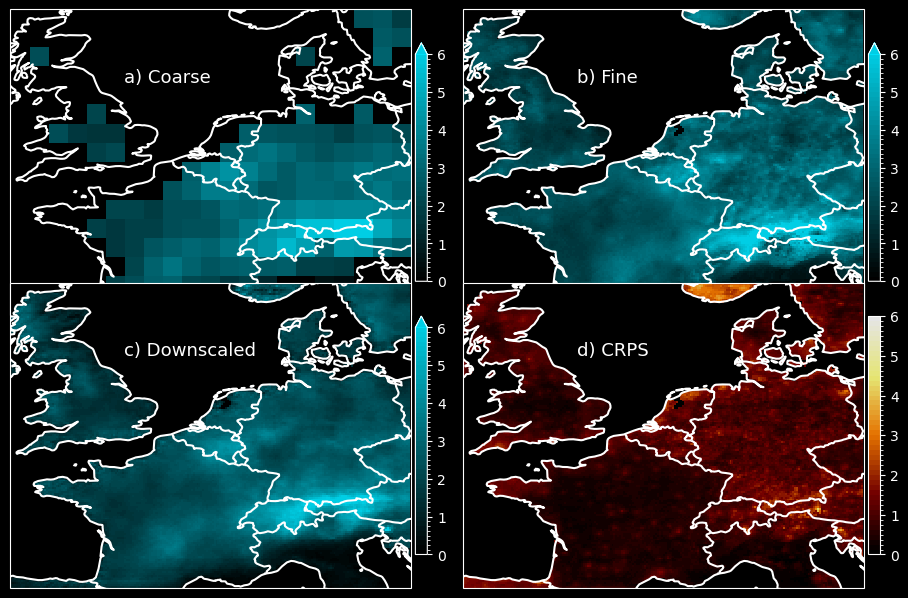

In [48]:
crps_data = ps.crps_ensemble(observations=fine_data_test.sel(time=slice(date1, date2)), 
                             forecasts=downscaled_data.sel(time=slice(date1, date2)))
# Convert to xarray DataArray if necessary
crps_data = xr.DataArray(crps_data, dims=["time", "lat", "lon"], coords={"time": fine_data_test.sel(time=slice(date1, date2)).time,
                                                                         "lat": fine_data_test.lat, 
                                                                         "lon": fine_data_test.lon,
                                                                        })

# Define the colormap colors
colors_blues2black = [(0, 0, 0), (0, 0.90, 1)]  # Blue to Black
colors_RdBlBu = [(1, 0, 0), (0, 0, 0), (0, 0.90, 1)]  # Blue to Black

# Create the colormap
cmap_name = 'BluesToBlack'
blues_to_black = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors_blues2black)
Rd_bl_Bu = mcolors.LinearSegmentedColormap.from_list('RdBlBu', colors_RdBlBu)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10), sharex=True, sharey=True,
                        subplot_kw=dict(projection=ccrs.PlateCarree(), facecolor='black'),
                        gridspec_kw={'wspace': -0.05, 'hspace': -0.45})

# Define the plots list
plots = [coarse_data_test, fine_data_test, downscaled_data.mean(dim='number'), crps_data]
cmap = [blues_to_black, blues_to_black, blues_to_black, 'afmhot']
levels = [np.arange(0,6.125,0.125), np.arange(0,6.125,0.125), np.arange(0,6.125,0.125), np.arange(0,6.125,0.125)]
title = ['a) Coarse','b) Fine','c) Downscaled','d) CRPS']
ticks = [np.arange(0,7,1), np.arange(0,7,1), np.arange(0,7,1), np.arange(0,7,1)]

for i, ax in enumerate(axs.flatten()):
    if i != (len(plots) - 1):
        plots[i].sel(time=slice(date1, date2)).mean('time').plot(cmap=cmap[i], levels=levels[i], 
                                                                 ax=ax, cbar_kwargs={'orientation':'vertical',
                                                                                    'pad':0.01, 'label':'',
                                                                                    'shrink':0.48, 'drawedges':False,
                                                                                    'ticks': ticks[i], },
                                                                 alpha=0.90)
    else:
        plots[-1].sel(time=slice(date1, date2)).mean('time').plot(cmap=cmap[i], levels=levels[i], 
                       ax=ax, cbar_kwargs={'orientation':'vertical',
                                           'pad':0.01, 'label':'',
                                           'shrink':0.48, 'drawedges':False,
                                           'ticks': ticks[i], },
                       alpha=0.90)
    
    ax.text(0, 55.2, f'{title[i]}', size=13, color='white')
    ax.coastlines(linewidth=1.5, color='white')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.5, edgecolor='white')
    ax.patch.set_facecolor('black')

plt.show()